In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose, result_dict_to_latent_variable_convert_z_to_beta

In [120]:
from PFNExperiments.LatentFactorModels.GenerativeModels.FactorAnalysis.BasicFA import make_fa_program_normal_weight_prior, make_fa_program_normal_weight_prior_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [121]:
N = 50
P = 5
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [122]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(5)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("z_dim", curriculum.constant_scheduler(3)),
    ("w_var", curriculum.constant_scheduler(1.0)),
    ("mu_var", curriculum.constant_scheduler(1.0)),
    ("a1_psi_var", curriculum.constant_scheduler(5.0)),
    ("b1_psi_var", curriculum.constant_scheduler(2.0)),
])
#curriculum.plot_all_schedules()

In [123]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_fa_program_normal_weight_prior_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [124]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [125]:
sample_batch = next(iter(epoch_loader[0][0]))

In [126]:
for key, value in sample_batch.items():
    print(key, value.shape)

x torch.Size([1024, 50, 5])
z torch.Size([1024, 3])
mu torch.Size([1024, 5])
w torch.Size([1024, 12])
psi torch.Size([1024, 5])
beta torch.Size([1024, 3])
time torch.Size([1024])
base_sample_beta torch.Size([1024, 3])


####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 13.86it/s]


{'X': {'mean': tensor(-0.0143), 'variance': tensor(3.8447), 'min': tensor(-11.0126), 'max': tensor(12.4411), 'mean_mean': tensor([-0.0282,  0.0155, -0.0287, -0.0135, -0.0168]), 'variance_mean': tensor([0.4898, 0.4980, 0.4969, 0.4996, 0.4975]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(-0.0048), 'variance': tensor(0.9941), 'min': tensor(-3.9326), 'max': tensor(3.5641), 'mean_mean': tensor(-0.0048), 'variance_mean': tensor(0.9829), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([-5.0466e-03,  3.5231e-05, -9.4205e-03])
Variance: tensor([0.9822, 1.0021, 0.9980])
Min: tensor([-3.6766, -3.9326, -3.4445])
Max: tensor([3.3550, 3.5641, 3.5596])
Mean of means: -0.004810605198144913
Mean of variances: 0.9829058647155762
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0086,  0.0042, -0.0346,  0.0069, -0.0103])
Variance: tensor([0.9581, 0.9881, 0.9785, 1.0032, 1.0110])
Min: tensor([-3.2282, -3.5826, -3.4549, -4.2793, -3.704

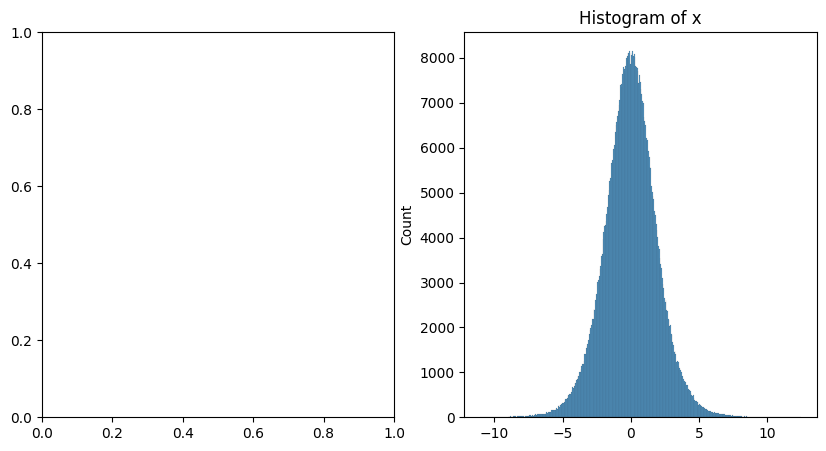

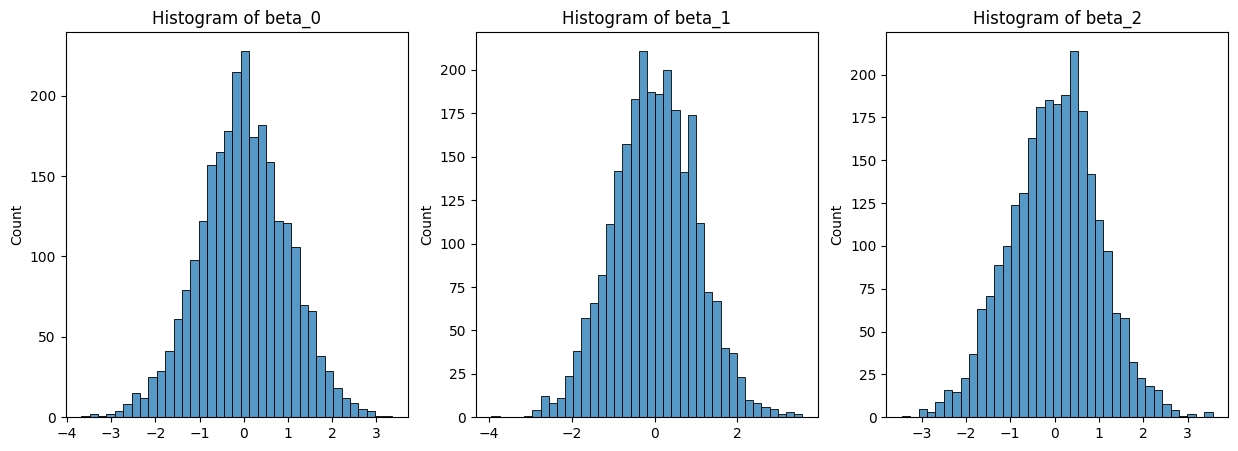

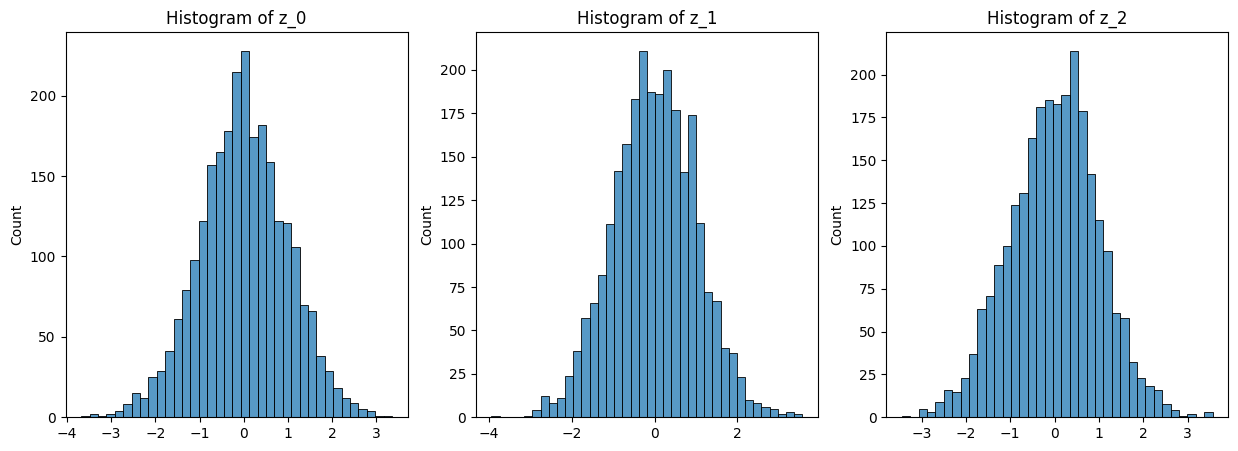

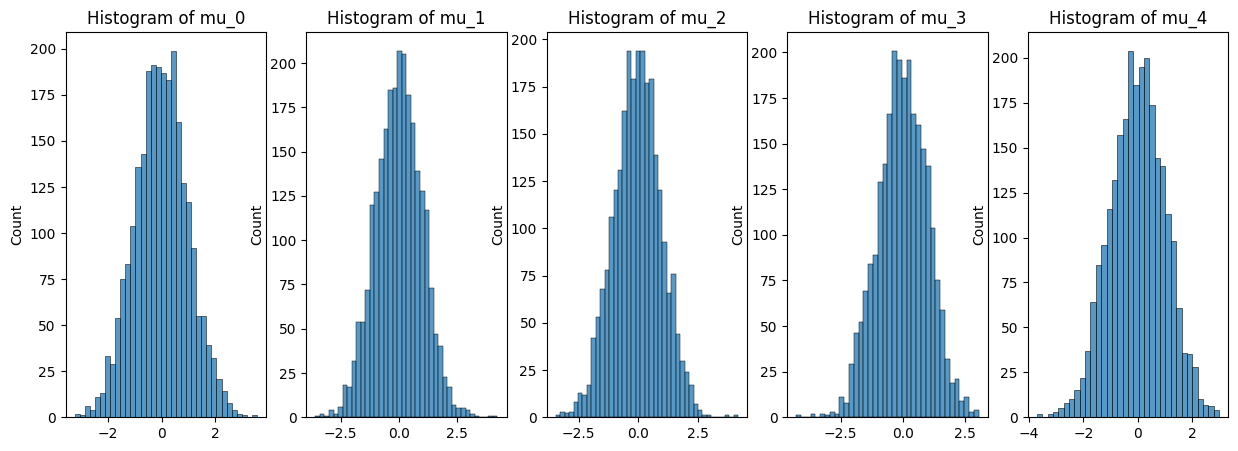

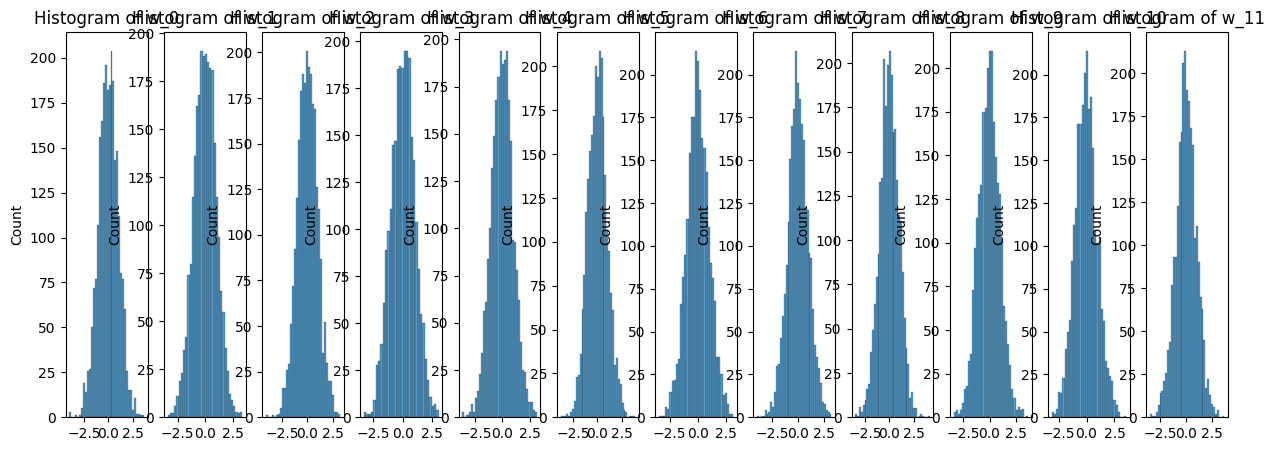

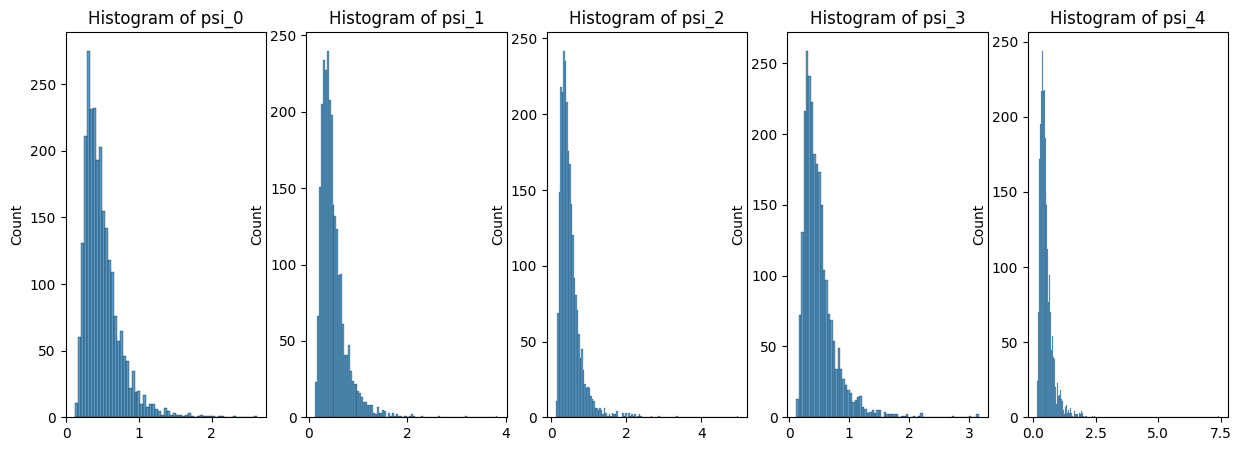

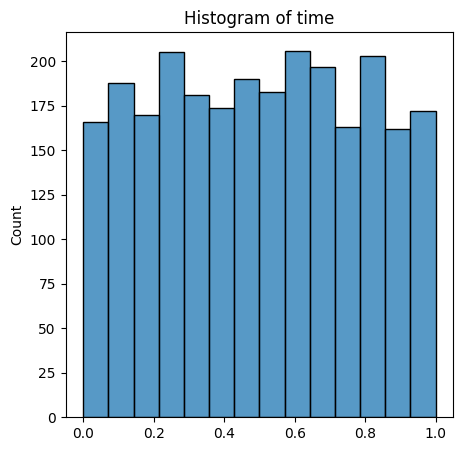

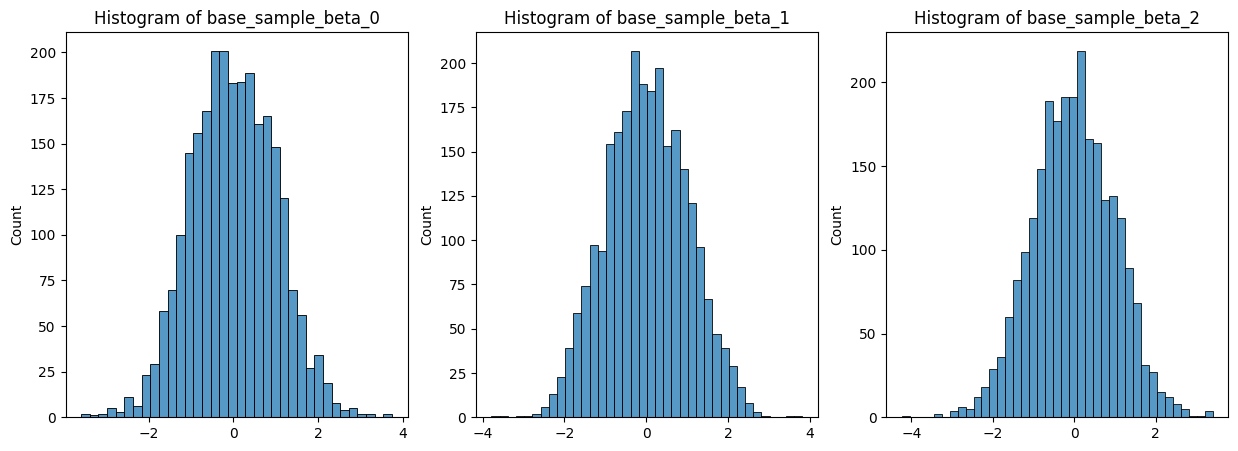

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


{'X': {'mean': tensor(0.0135), 'variance': tensor(3.7794), 'min': tensor(-10.0646), 'max': tensor(10.9642), 'mean_mean': tensor([ 0.0400,  0.0092,  0.0260, -0.0053, -0.0021]), 'variance_mean': tensor([0.5044, 0.5052, 0.5000, 0.5011, 0.5063]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.0081), 'variance': tensor(0.9625), 'min': tensor(-3.7305), 'max': tensor(4.1378), 'mean_mean': tensor(0.0081), 'variance_mean': tensor(0.9584), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([ 0.0138,  0.0259, -0.0155])
Variance: tensor([0.9515, 0.9623, 0.9738])
Min: tensor([-3.1954, -3.7305, -3.0889])
Max: tensor([4.1378, 3.3782, 3.5195])
Mean of means: 0.00805848278105259
Mean of variances: 0.958419144153595
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([ 0.0053, -0.0139,  0.0100, -0.0067, -0.0277])
Variance: tensor([0.9784, 1.0614, 0.9873, 0.9990, 0.9880])
Min: tensor([-3.1772, -3.8274, -3.3401, -3.4321, -3.2532])
Max: tensor([3

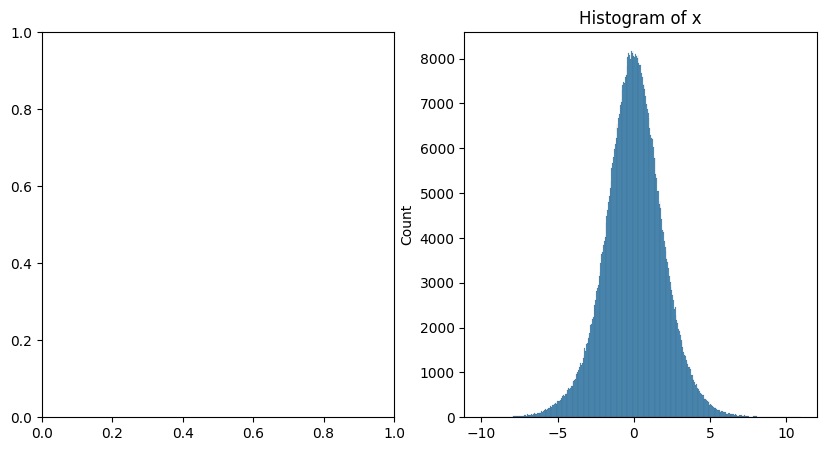

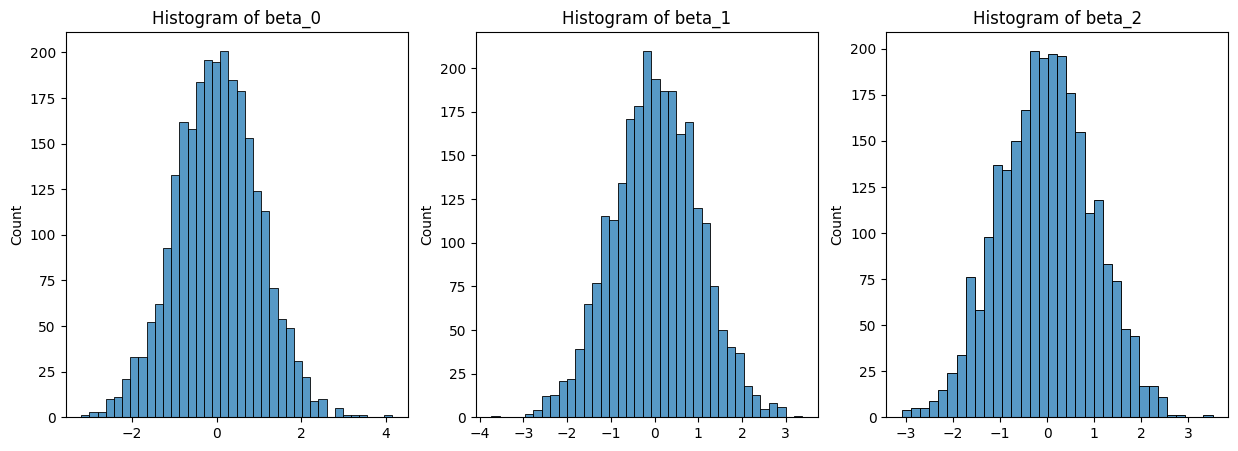

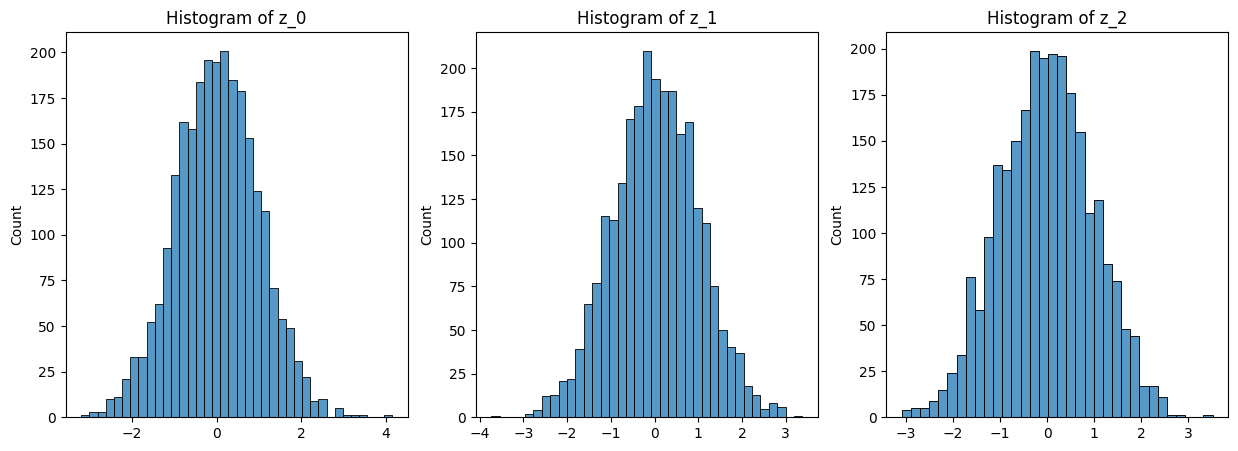

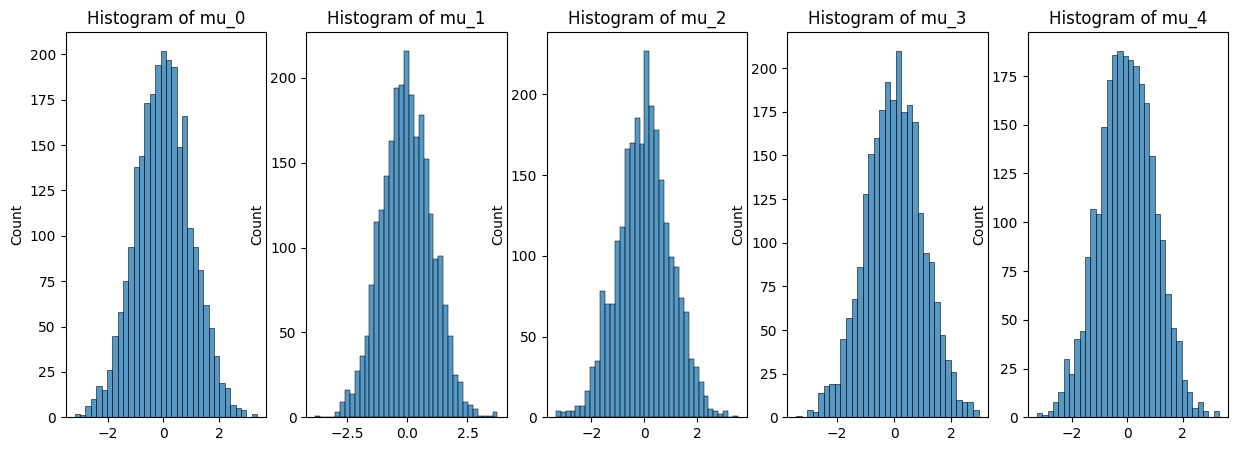

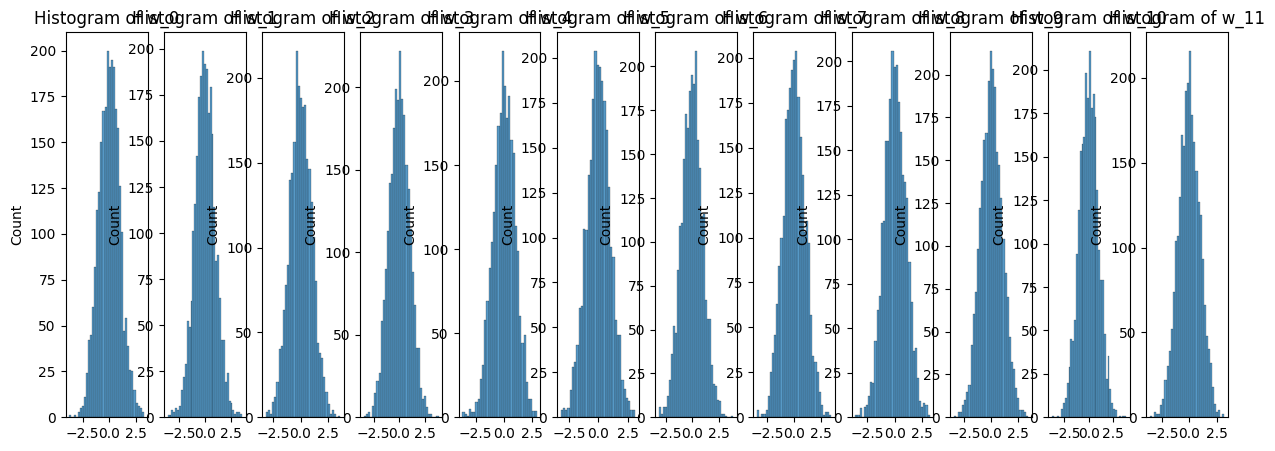

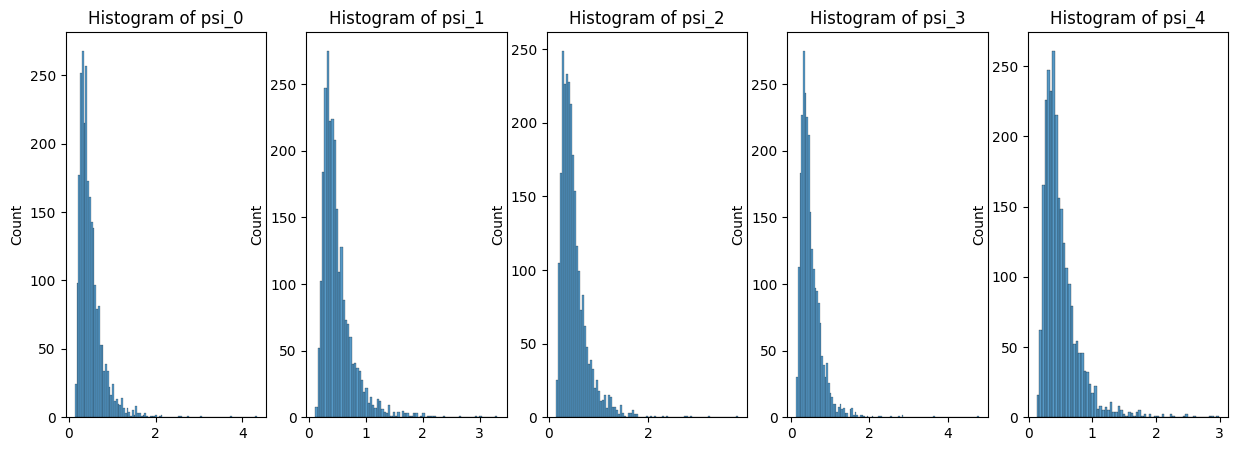

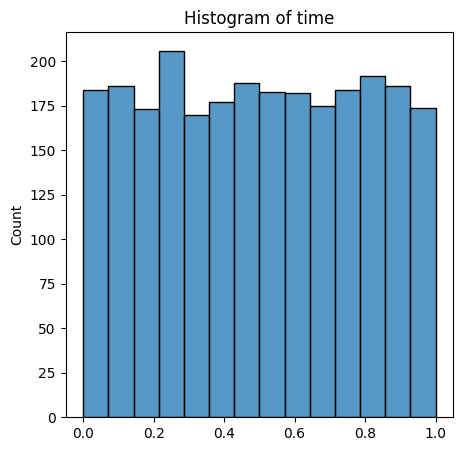

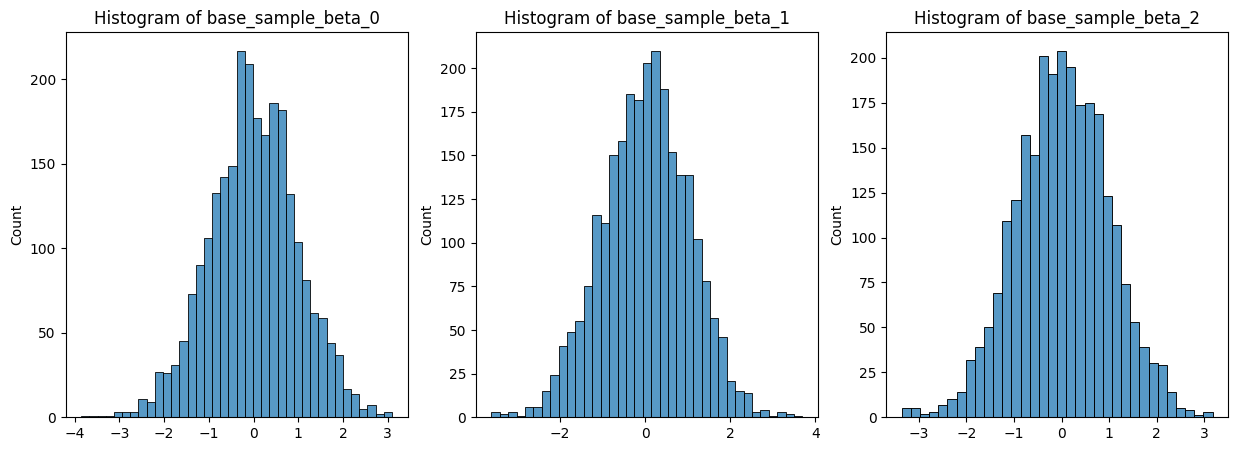

[{'X': {'mean': tensor(-0.0143),
   'variance': tensor(3.8447),
   'min': tensor(-11.0126),
   'max': tensor(12.4411),
   'mean_mean': tensor([-0.0282,  0.0155, -0.0287, -0.0135, -0.0168]),
   'variance_mean': tensor([0.4898, 0.4980, 0.4969, 0.4996, 0.4975]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(-0.0048),
   'variance': tensor(0.9941),
   'min': tensor(-3.9326),
   'max': tensor(3.5641),
   'mean_mean': tensor(-0.0048),
   'variance_mean': tensor(0.9829),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(0.0135),
   'variance': tensor(3.7794),
   'min': tensor(-10.0646),
   'max': tensor(10.9642),
   'mean_mean': tensor([ 0.0400,  0.0092,  0.0260, -0.0053, -0.0021]),
   'variance_mean': tensor([0.5044, 0.5052, 0.5000, 0.5011, 0.5063]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.0081),
   'variance': tensor(0.9625),
   'min': tensor(-3.7305),
   'max': tensor(4.1378),
   'mean_mean': tensor(0.0081),
   'varianc

In [127]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [128]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [129]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

In [95]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 5]), torch.Size([1024, 3]))

In [96]:
2*K

6

In [97]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [98]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [99]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [100]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [101]:
trainer.validate()

100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


{'loss_mean': 2.140406608581543,
 'loss_median': 2.1383259296417236,
 'loss_std': 0.046656783670186996}

In [102]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 1.0, 'mu_var': 1.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 0


100%|██████████| 49/49 [00:16<00:00,  2.92it/s]


Epoch 0:
Training: {'loss_mean': 2.655900716781616, 'loss_median': 2.597168207168579, 'loss_std': 0.23206891119480133}
Validation: {'loss_mean': 2.091317892074585, 'loss_median': 2.0907630920410156, 'loss_std': 0.05067567899823189}
Validation curriculum: {'loss_mean': 2.105006694793701, 'loss_median': 2.1033315658569336, 'loss_std': 0.05810012295842171}
Time: 150.38796663284302
Learning rate: [2.2956007119594385e-05]


----------------------------------------------------------------------------------------------------
Saving model
Curriculum parameters: {'n': 10, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 1.0, 'mu_var': 1.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 249856


 52%|█████▏    | 128/244 [01:13<01:06,  1.74it/s]


KeyboardInterrupt: 

In [103]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_fa_program_normal_weight_prior(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 5, 'z_dim': 3, 'w_var': 1.0, 'mu_var': 1.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0}


In [117]:
pprogram1()

{'x': tensor([[-1.1808,  2.7899,  0.3236,  4.4736, -0.8799],
         [-0.9469,  0.9838, -0.0200,  3.7409, -0.4298],
         [ 0.2035,  1.3770, -0.2677,  4.4392, -0.7859],
         [-0.5173,  0.6236,  0.0764,  4.6855, -1.4390],
         [-1.0839,  1.1881,  0.4819,  4.7908, -0.8742],
         [-1.5602,  1.9279,  0.3449,  3.9932, -1.1239],
         [-0.3607,  1.4134, -0.1535,  4.4865, -0.0772],
         [-0.8986,  1.3128, -0.7954,  3.7031,  0.0339],
         [ 0.7440,  1.1345,  0.8819,  4.8297, -0.4712],
         [-0.4607,  1.2291,  1.0496,  5.0562, -1.1599]]),
 'z': tensor([-0.7575,  0.9694,  0.1412]),
 'mu': tensor([-0.1123, -0.0980,  2.0934,  2.3366, -0.6003]),
 'w': tensor([ 0.9191,  0.6469,  1.8500,  1.4024, -0.8692,  0.4720, -1.1421,  1.2544,
          1.3784, -0.1519, -0.4198, -0.3358]),
 'psi': tensor([0.4202, 0.4640, 0.3470, 0.4727, 0.3049])}

In [104]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [105]:
x_test.shape

torch.Size([1024, 10, 5])

In [106]:
samples = full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


In [107]:
samples["beta"].shape

torch.Size([1000, 3])

In [108]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000, discrete_z=False)

In [109]:
models

[Hamiltonian Monte Carlo,
 Variational Inference with guide: AutoDiagonalNormal(),
 Variational Inference with guide: AutoMultivariateNormal(),
 Variational Inference with guide: AutoLaplaceApproximation(),
 Variational Inference with guide: AutoIAFNormal(),
 Variational Inference with guide: AutoStructured()]

In [110]:
"""
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)
"""

evaluation = Evaluate(
    posterior_model = models[1],
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_posterior_model = result_dict_to_latent_variable_convert_z_to_beta,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [111]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:27<00:27, 27.21s/it]

....................


 36%|███▌      | 36/100 [00:00<00:00, 200.66it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 233.82it/s]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

 34%|███▍      | 34/100 [00:00<00:00, 330.46it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 275.84it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,Variational Inference with guide: AutoDiagonal...,gt,25.698158,3.296479,NaN,-246.170515,0.744946,0.742365,0.012500,0.001613,NaN,158.181718,0.252022,0.274271
1,Hamiltonian Monte Carlo,gt,25.798306,3.289000,NaN,-3.013300,0.421981,0.568523,0.003122,0.001913,NaN,0.572608,0.276191,0.012878


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,Variational Inference with guide: AutoDiagonal...,Hamiltonian Monte Carlo,0.5,0.5,NaN,0.5,1.0,1.0



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,Variational Inference with guide: AutoDiagonal...,Hamiltonian Monte Carlo,1.418548,2.660692,0.991,0.065084,0.007487,0.004243


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0  Variational Inference with guide: AutoDiagonal...  gt   
  1                            Hamiltonian Monte Carlo  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                          25.698158            3.296479   
  1                                          25.798306            3.289000   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                     NaN                   -246.170515   
  1                     NaN                     -3.013300   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                    0.744946                     0.742365   
  1                    0.421981                     0.568523   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.012500          0.001613   

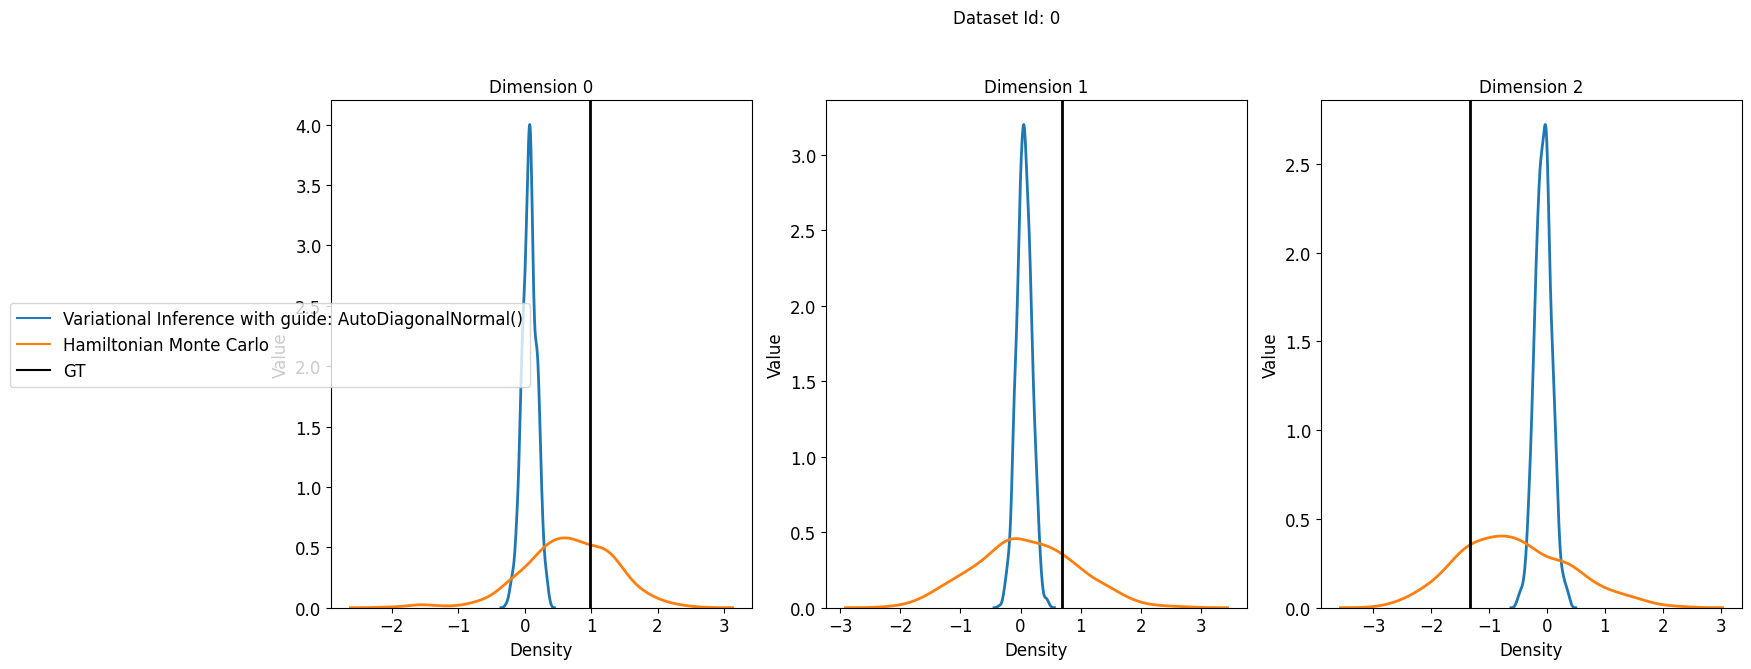

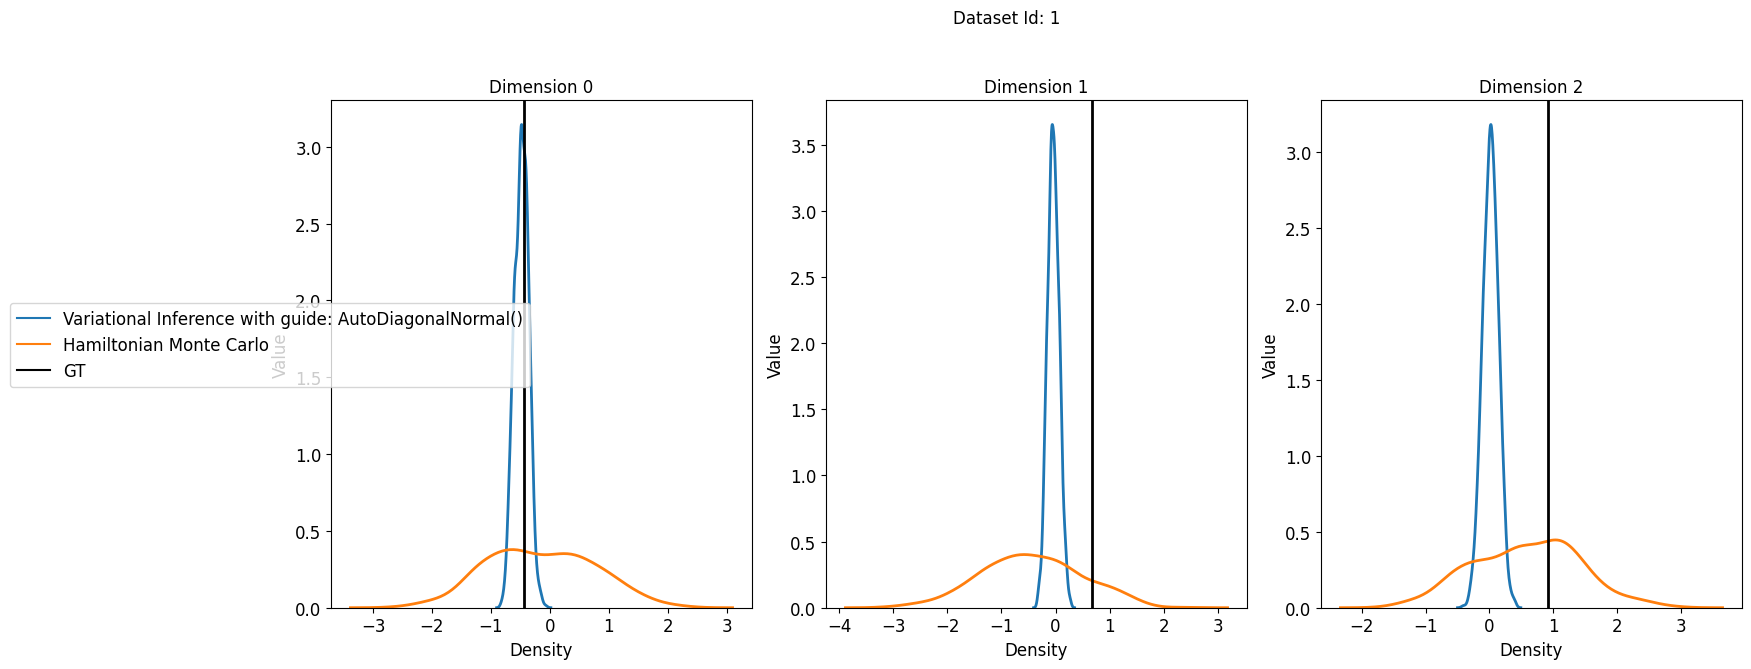

In [112]:
evaluation.plot_results()

In [113]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [114]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [115]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = [models[1]],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [116]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:30<00:30, 30.68s/it]

....................


Sampling posterior: 100%|██████████| 2/2 [01:06<00:00, 33.13s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,1.014386e+11,7.742189,1.0,2.992878e+09,3.371748e-07,0.0


P-values:


""


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  
                                               Model 2  \
  0  Variational Inference with guide: AutoDiagonal...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                     1.014386e+11  7.742189   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean  \
  0               1.0                                    2.992878e+09   
  
          Std_MMD  Std_cst_roc_auc  
  0  3.371748e-07              0.0  },
 'test_results': {'model_comparison_among_each_other': Empty DataFrame
  Columns: []
  Index: []},
 'res_df': {'model_comparison_among_each_other': {('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x000001F0C326DC30>',
    'Variational Inference with guide: AutoDiagonalNormal()'):    Wasserstein_di